# Clustering

### Libraries

In [336]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

### Load data

In [338]:
df = pd.read_csv("Wholesale customers data.csv")
print(f'The dataset contains {df.shape[0]} samples and {df.shape[1]} features.\n')

# Let's preview the first few rows

df.head()

The dataset contains 440 samples and 8 features.



,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [339]:
# rename last feature
df = df.rename(columns={"Delicassen": "Delicatessen"})
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [340]:
# A few more steps for better understanding

print(df.info(), '\n\n\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicatessen      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None 



          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000 

In [341]:
# all features are numeric as expected
# summary statistics show that scaling is needed 
# and maybe deal with outliers or keep them?? stay tuned

In [342]:
# the info() function showed that there are no null values in df but let's check once more for our OCD

df.isnull().sum()

# yep, still no nulls

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

In [343]:
# what about duplicates?

# df before
print(df.shape)

df.drop_duplicates(inplace=True)

#df after
print(df.shape)

# there are no duplicate values in the df

(440, 8)
(440, 8)


In [344]:
# the 'Channel' variable looks like a y class vector
# it won't be used in this project but lets see the balance 

y = df['Channel']
y.value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [345]:
# the features "Channel" & "Region" will be excluded for now since only the products are useful for our analysis 

X = df.drop(["Channel", "Region"], axis=1)
#X.head()

In [346]:
# outliers detection

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

outliers = (X < lower_limit) | (X > upper_limit)
outliers.sum()

Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicatessen        27
dtype: int64

In [347]:
# it was decided to keep the outliers
# the project is about clustering and outliers could showcase valuable results regarding the segmentations
# the dataset has only 440 rows
# in case of dropping them, the dtataset would be relatively small for proper analysis

### Exploratory Data Analysis (EDA)

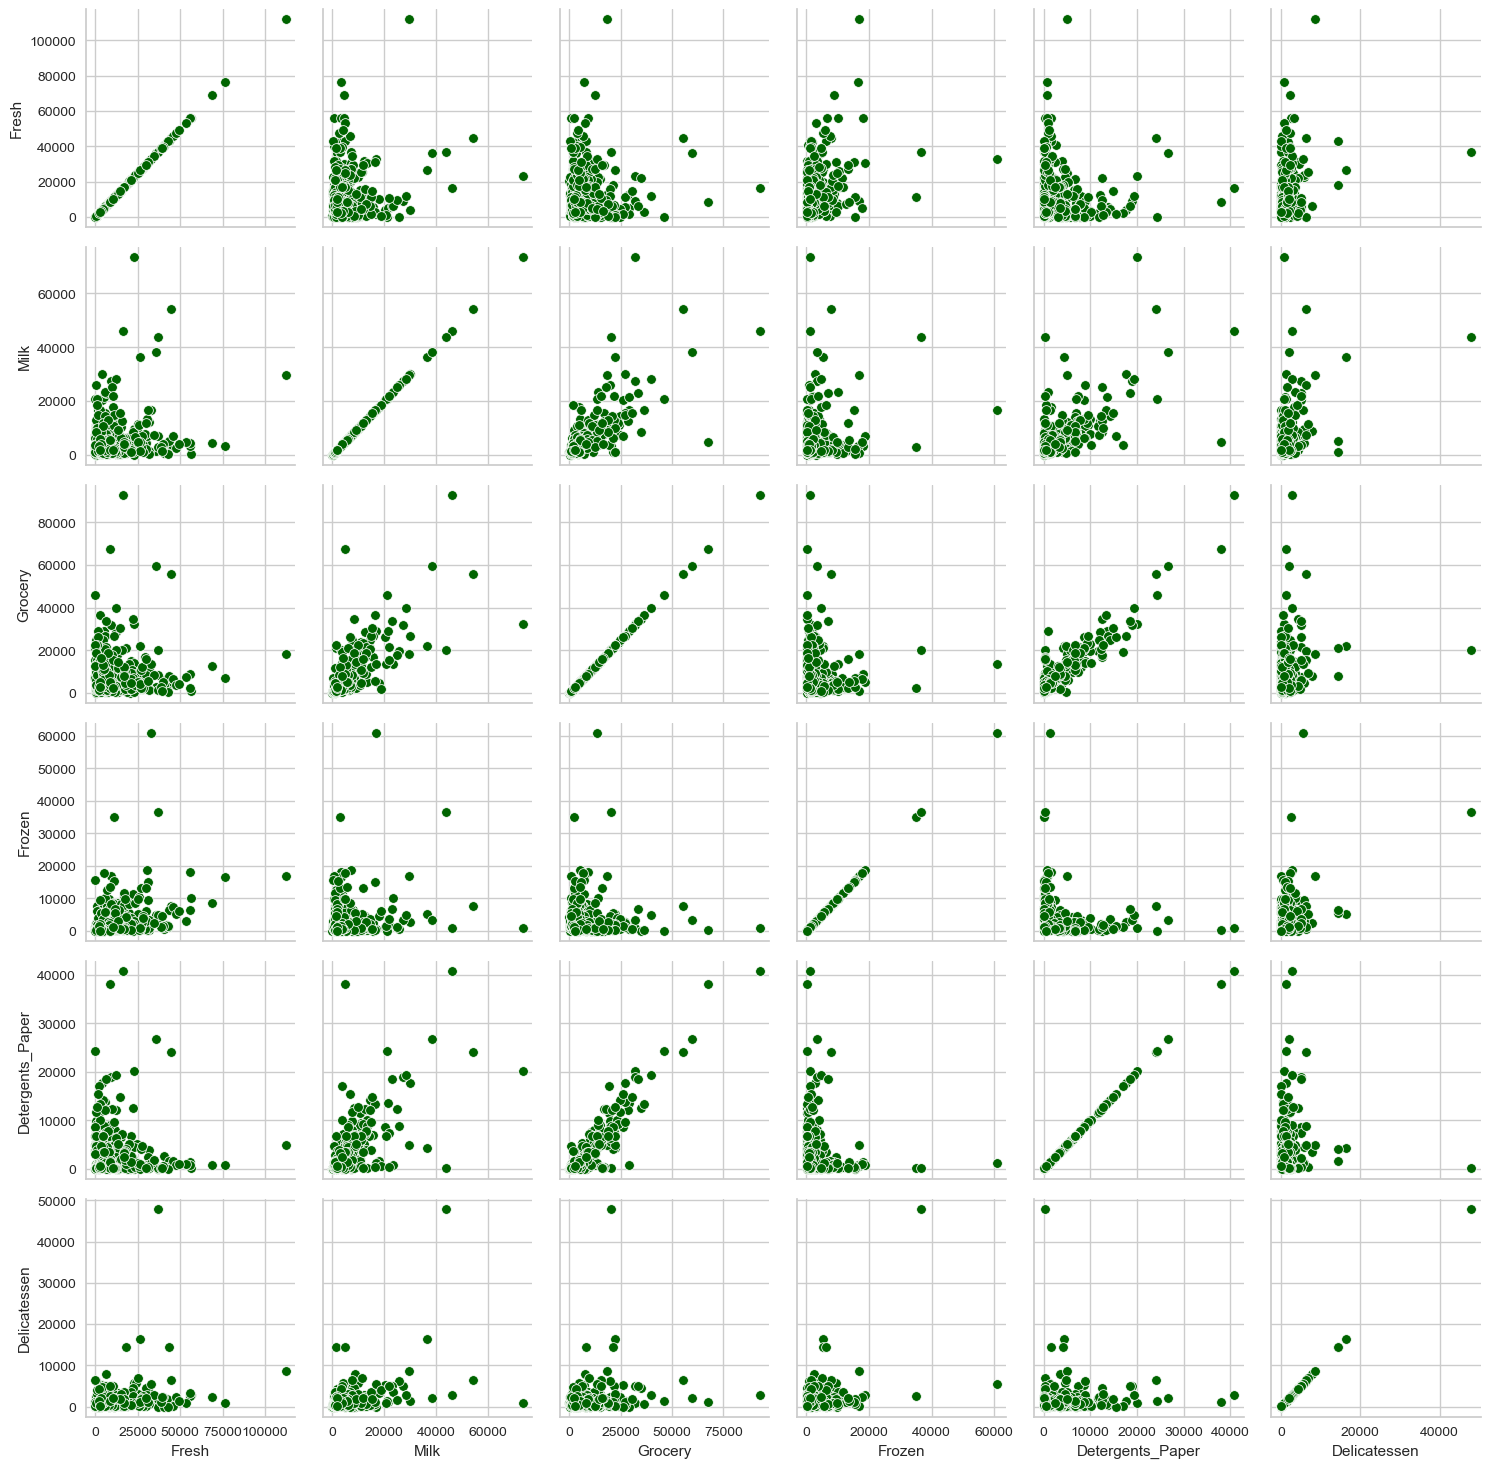

In [349]:
# scatterplot matrix to check all the distributions of the corresponding variables at once

g = sns.PairGrid(X)
g.map(sns.scatterplot, color="darkgreen");

In [350]:
# features "Grocery" and "Detergents_Paper" seem to be highly correlated
# let's confirm above statement with a Pearson correlation matrix

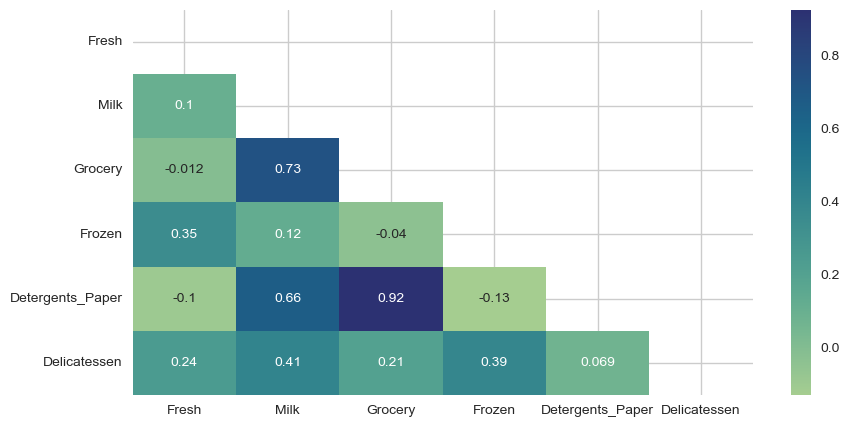

In [351]:
zero = np.zeros_like(X.corr())
triangle_indices = np.triu_indices_from(zero)
zero[triangle_indices] = True

plt.figure(figsize=(10, 5))
sns.heatmap(X.corr(), 
            mask=zero, 
            cmap="crest", 
            annot=True, 
            annot_kws={'size': 10})

sns.set_style('whitegrid')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()   

In [352]:
# indeed the aforementioned features are highly correlated
# nothing PCA can't fix

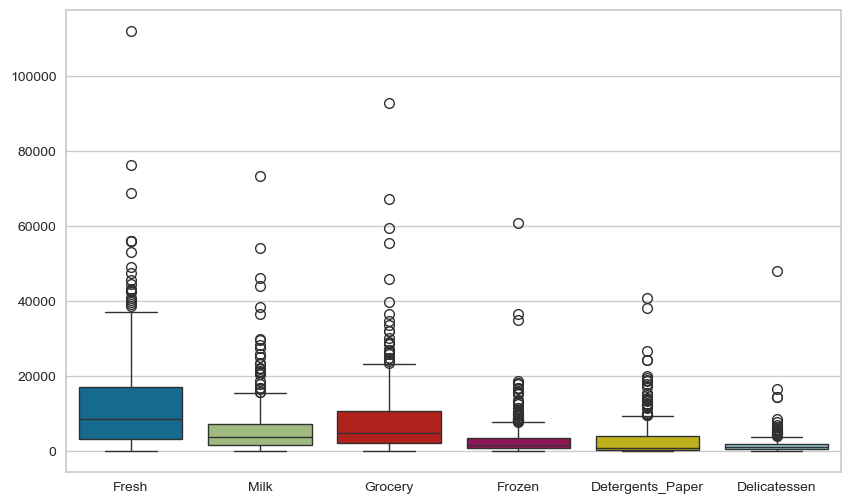

In [353]:
# check for any differences in feature ranges

plt.figure(figsize=(10,6))
ax = sns.boxplot(data=X)
plt.show();

### Scaling

In [355]:
# clustering algorithms use distance to create clusters so scaling is necessary (like everywhere)
# scaling converts the dataset into numpy array, therefore below it is converted back to dataframe at the same time

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

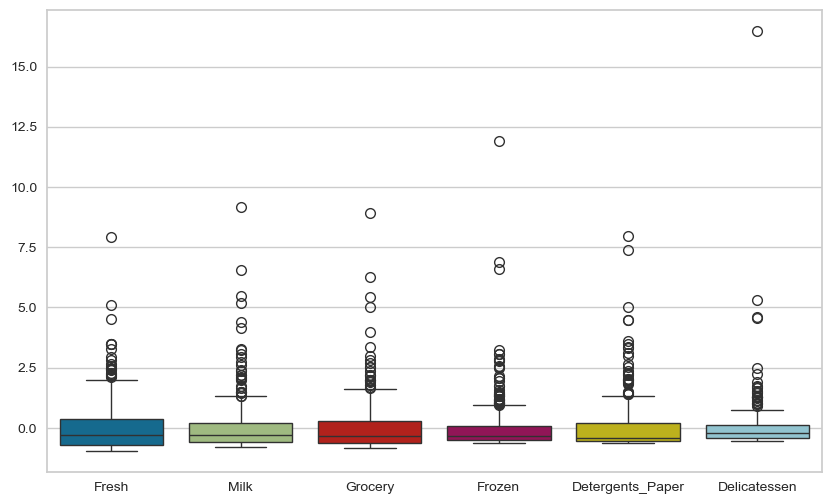

In [356]:
# again a box plot on scaled data for visual satisfaction

plt.figure(figsize=(10,6))
ax = sns.boxplot(data=X_scaled)
plt.show();

### Principal Component Analysis (PCA)

In [358]:
# our dataset is not huge, but still PCA should be applied as a dimensionality reduction method

pca = PCA()

# create a name for each Principal Component for up to the number of dimensions (6)
PCs = ['PC'+str(i+1) for i in range(X_scaled.shape[1])]
print(PCs)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']


In [359]:
# pc scores

pc_scores = pd.DataFrame(pca.fit_transform(X_scaled), columns=PCs)

print(pc_scores.shape)
pc_scores.head()

(440, 6)


,PC1,PC2,PC3,PC4,PC5,PC6
0,0.193291,-0.305100,0.140878,-0.486432,0.495281,-0.007414
1,0.434420,-0.328413,-0.319007,-0.178830,0.365579,0.054572
2,0.811143,0.815096,-1.523416,-1.254082,-0.379054,-0.277539
3,-0.778648,0.652754,-0.163012,0.380060,-0.276138,0.060718
4,0.166287,1.271434,-0.066279,-0.826227,-0.394211,-0.026825


In [360]:
# let's decide how many PCs to keep

# Calculate the explained variance
exp_var = [i*100 for i in pca.explained_variance_ratio_]

# Calculate the cumulative variance
cum_var = np.cumsum(pca.explained_variance_ratio_*100)

# Combine both in a data frame
pca_var = pd.DataFrame(data={'exp_var': exp_var, 'cum_var': cum_var}, index=PCs)
pca_var

,exp_var,cum_var
PC1,44.082893,44.082893
PC2,28.376400,72.459292
PC3,12.334413,84.793705
PC4,9.395504,94.189209
PC5,4.761272,98.950481
PC6,1.049519,100.000000


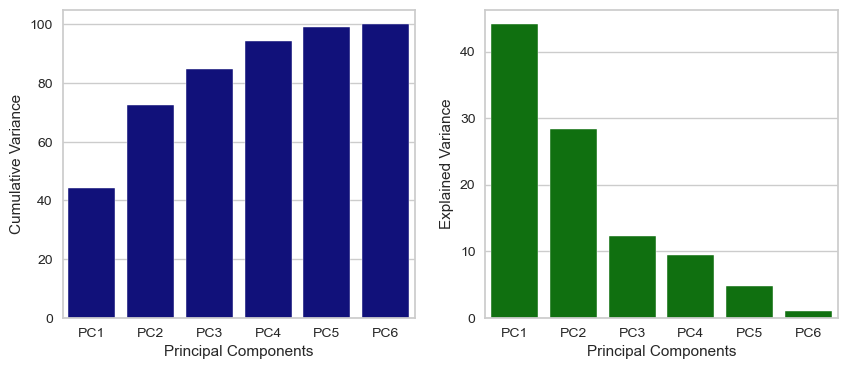

In [361]:
# disclaimer: three following cells are plots of exp_var & cum_var to have options for presentation plots :)

# explained and cumulative variance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

sns.barplot(x=pca_var.index, y='cum_var', data=pca_var, ax=ax1, color="darkblue")
ax1.set(xlabel='Principal Components', ylabel='Cumulative Variance')

sns.barplot(x=pca_var.index, y='exp_var', data=pca_var, ax=ax2, color="green")
ax2.set(xlabel='Principal Components', ylabel='Explained Variance')

plt.show()

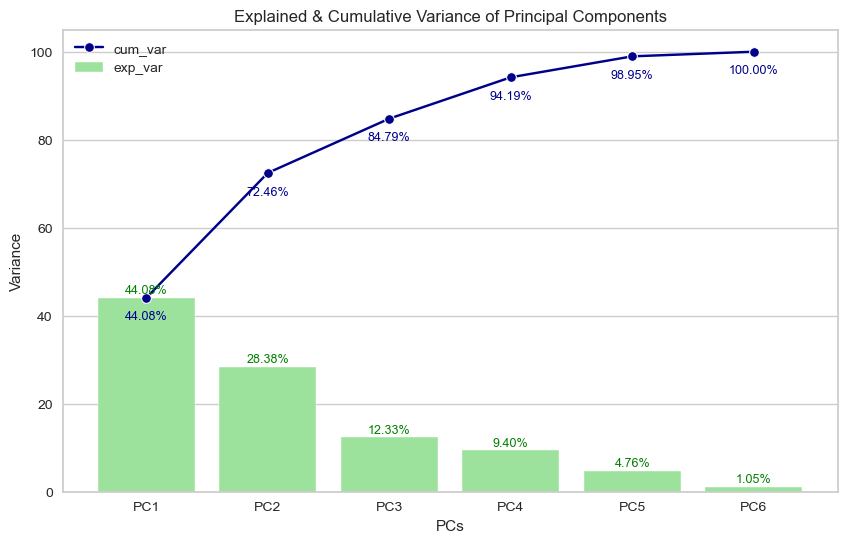

In [362]:
plt.figure(figsize=(10,6))


sns.barplot(x=pca_var.index, y='exp_var', data=pca_var, color='lightgreen', label='exp_var')

sns.lineplot(x=pca_var.index, y='cum_var', data=pca_var, marker='o', label='cum_var', color='darkblue')

for i, val in enumerate(pca_var['exp_var']):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=9, color='green')

for i, val in enumerate(pca_var['cum_var']):
    plt.text(i, val - 5, f"{val:.2f}%", ha='center', fontsize=9, color='darkblue')

plt.ylabel('Variance')
plt.xlabel('PCs')
plt.title('Explained & Cumulative Variance of Principal Components')
plt.show()


Explained Variance:
 [44.08289288112804, 28.376399526616936, 12.334412896786477, 9.395503752971498, 4.761272400688668, 1.049518541808375]


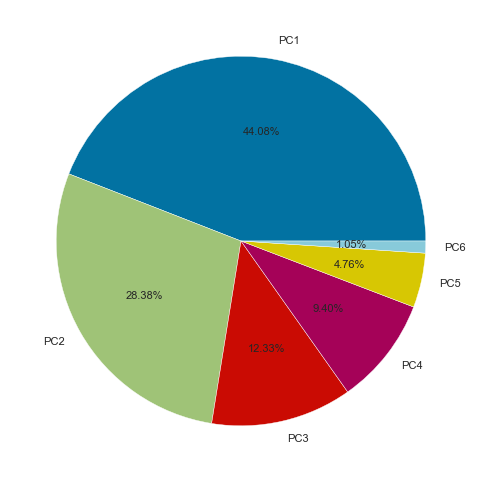

In [363]:
plt.figure(figsize=(6,6))

plt.pie(x=exp_var,labels=["PC1","PC2","PC3","PC4","PC5","PC6"],autopct="%.2f%%", textprops={'fontsize': 8})
print("Explained Variance:\n", exp_var)

In [364]:
# decide on the threshold
# 4 or 5 PCs should do the work, let's go with 5 (that cover 98.95% of the variance) to be sure

# df before threshold
print('df before PCs selection:', pc_scores.shape)

pc_scores = pc_scores.iloc[:, :5]

# df after threshold
print('df after PCs selection:', pc_scores.shape)

df before PCs selection: (440, 6)
df after PCs selection: (440, 5)


### Clustering Algorithms:

#### K-Means

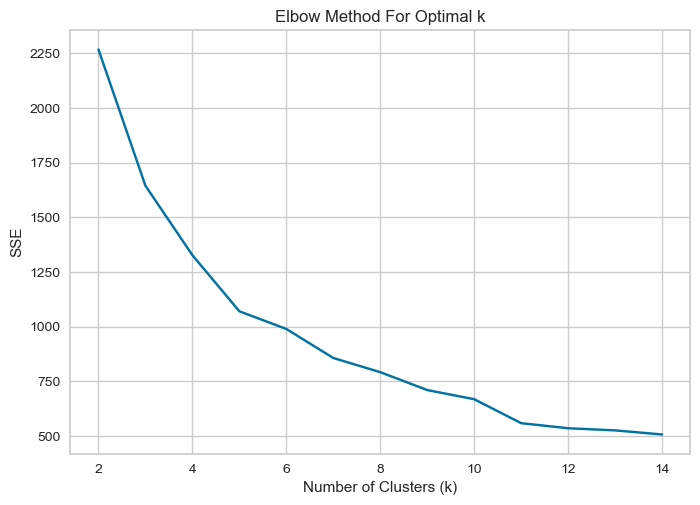

In [366]:
# elbow method to find optimal number of clusters

# initialize empty list to store k values
sum_of_squared_distances = []

# range to search for the optimal number of clusters
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)

    sum_of_squared_distances.append(km.inertia_)

# plot elbow
plt.plot(K, sum_of_squared_distances)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()


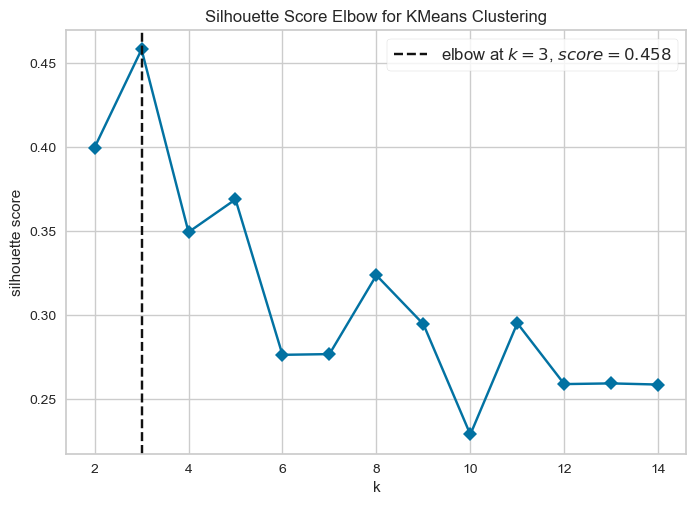

In [367]:
# hmm maybe 5 clusters? im not sure, let's try Silhouette Coef

model = KMeans(random_state=42) 

visualizer = KElbowVisualizer(model, k=(2, 15), metric='silhouette', timings=False)
visualizer.fit(X_scaled)    
visualizer.poof()
plt.show();

In [368]:
# i will trust the silhouette coef and go with 3 clusters
# now, let's fit the model on the pc_scores

opt_k = 3
kmodel_with_PCA = KMeans(n_clusters=opt_k, random_state=42)
kmodel_with_PCA.fit(pc_scores)
cluster_assignment_with_PCA = kmodel_with_PCA.labels_
cluster_assignment_with_PCA

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [369]:
#append cluster assignment to pc_scores df

pc_scores["KMCluster_PCA"] = cluster_assignment_with_PCA
pc_scores.head()

,PC1,PC2,PC3,PC4,PC5,KMCluster_PCA
0,0.193291,-0.305100,0.140878,-0.486432,0.495281,0
1,0.434420,-0.328413,-0.319007,-0.178830,0.365579,0
2,0.811143,0.815096,-1.523416,-1.254082,-0.379054,0
3,-0.778648,0.652754,-0.163012,0.380060,-0.276138,0
4,0.166287,1.271434,-0.066279,-0.826227,-0.394211,1


In [370]:
# generate the centroids that will be used in a minute for visualization purposes

print(kmodel_with_PCA.cluster_centers_)

[[-0.41168957 -0.23713369 -0.11713723 -0.03881547  0.02866219]
 [ 0.03590308  2.41605715  0.74640717  0.12683258 -0.18680912]
 [ 3.89132042 -0.9308506   0.13223317  0.20340216 -0.02683159]]


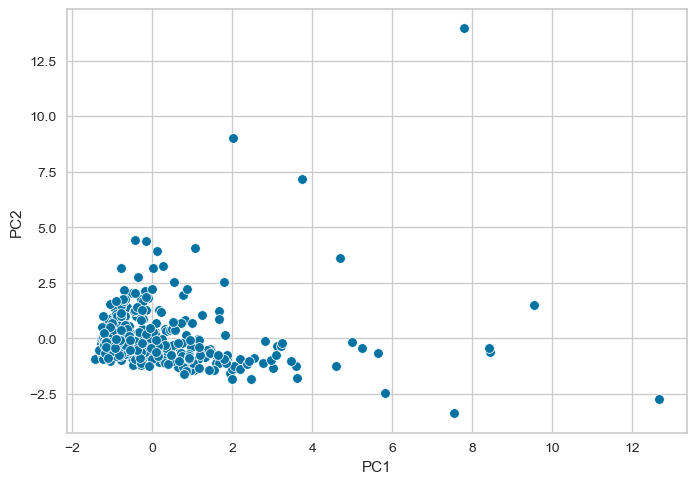

In [371]:
#let's plot the first two components without the hue of cluster assignment
sns.scatterplot(x="PC1", y="PC2", data=pc_scores)
plt.show();

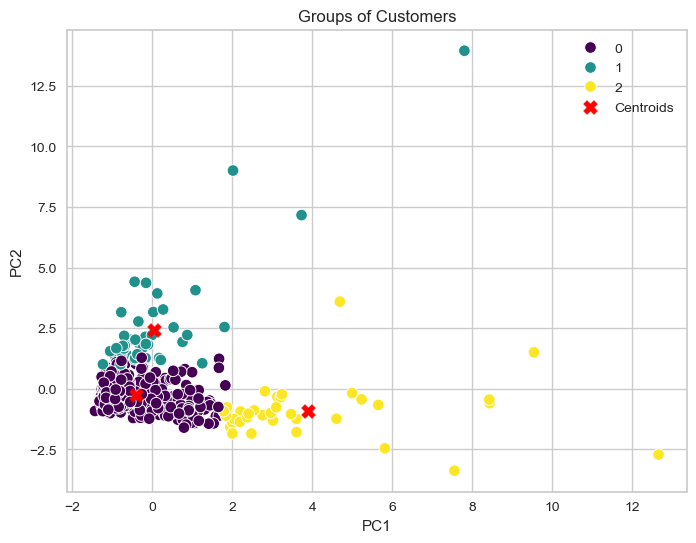

In [372]:
# now with the hue of cluster assignment and centroids

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pc_scores['PC1'], y=pc_scores['PC2'], hue=pc_scores['KMCluster_PCA'], palette='viridis', s=70)
plt.scatter(kmodel_with_PCA.cluster_centers_[:, 0], kmodel_with_PCA.cluster_centers_[:, 1], 
            s=100, marker='X', c='red', label='Centroids')

plt.title("Groups of Customers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

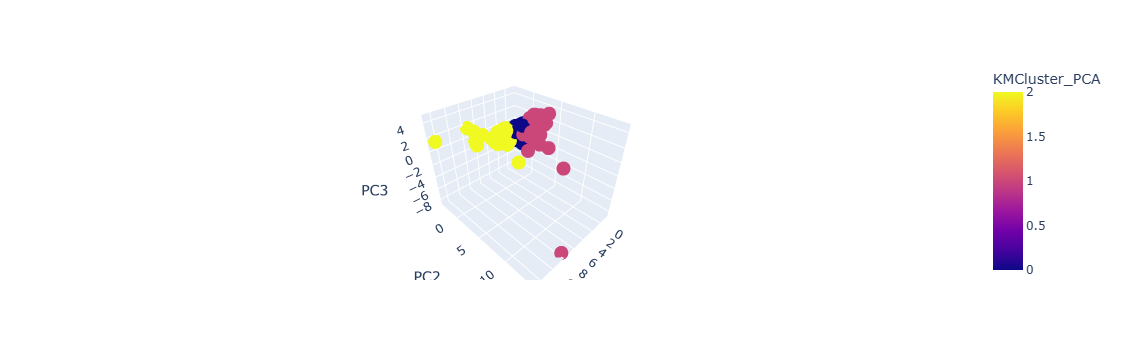

In [373]:
# 3d plot with first 3 PCs

import plotly.express as px

fig = px.scatter_3d(pc_scores, 
                    x="PC1", 
                    y="PC2", 
                    z="PC3", 
                    color='KMCluster_PCA') 
fig.show()

### t-SNE

In [375]:
# dimensionality reduction technique used mostly for visualization

tsne = TSNE(random_state=42)

In [376]:
#fit scaled data to T-SNE function

tsne_scores = pd.DataFrame(tsne.fit_transform(X_scaled), columns=["TSNE1", "TSNE2"])

print(tsne_scores.shape)
tsne_scores.head()

(440, 2)


,TSNE1,TSNE2
0,8.289819,2.971354
1,13.411434,-1.447491
2,11.663534,3.007109
3,-20.079727,6.076640
4,1.823331,10.755340


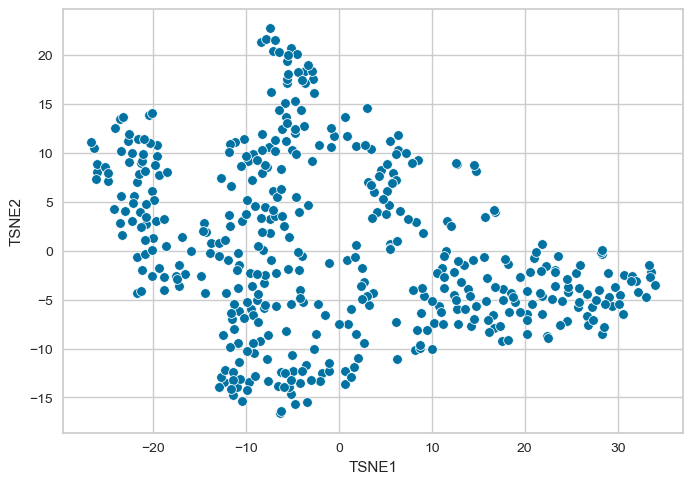

In [416]:
# plot t-sne components without hue

sns.scatterplot(x="TSNE1", y="TSNE2", data=tsne_scores)
plt.show();

In [418]:
# fit model on scaled (X) data

kmodel_with_tSNE = KMeans(n_clusters=opt_k, random_state=42)
kmodel_with_tSNE.fit(X_scaled)
cluster_assignment_with_tSNE = kmodel_with_tSNE.labels_
cluster_assignment_with_tSNE

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [420]:
# append cluster labels to df

tsne_scores["KMCluster_tSNE"] = cluster_assignment_with_tSNE
tsne_scores.head()

,TSNE1,TSNE2,KMCluster_tSNE
0,8.289819,2.971354,0
1,13.411434,-1.447491,0
2,11.663534,3.007109,0
3,-20.079727,6.076640,0
4,1.823331,10.755340,1


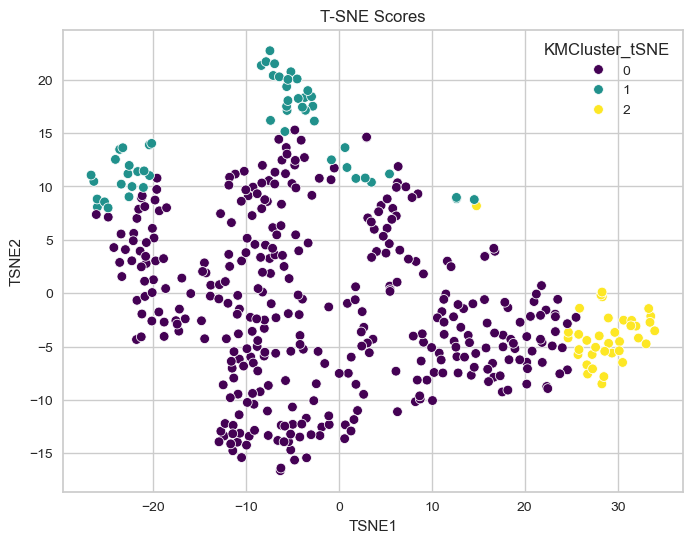

In [422]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='TSNE1', 
                y='TSNE2', 
                data=tsne_scores, 
                hue= "KMCluster_tSNE",
                palette="viridis"
               ).set_title('T-SNE Scores')

plt.show()

### Findings

In [425]:
# assigning clusters to original dataset

df['KMCluster_PCA'] = cluster_assignment_with_PCA 
df.head()

# mean for each feature in each cluster
cluster_means = df.groupby('KMCluster_PCA')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']].mean()
cluster_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
KMCluster_PCA,,,,,,
0,9087.728814,4245.451977,5838.533898,2218.850282,1907.844633,1105.418079
1,35530.510204,5871.306122,6213.673469,10095.306122,947.000000,3849.571429
2,8704.864865,20534.405405,30466.243243,1932.621622,14758.837838,2459.351351


In [427]:
# let's try to define customers based on their respective cluster

print('General mean feature values for reference: \n\n', df.iloc[:, 2:8].describe().loc[['mean']].round(2))

# Cluster 0:
# This cluster does not deviate largely from the general mean of the features.
# Probably represents customers with basic shopping needs

# Cluster 1:
# Represents customers with interest in fresh produce, frozen products and more gourmet and high-quality foods

# Cluster 2:
# These customers are buying mostly milk, groceries and household products

General mean feature values for reference: 

         Fresh     Milk  Grocery   Frozen  Detergents_Paper  Delicatessen
mean  12000.3  5796.27  7951.28  3071.93           2881.49       1524.87


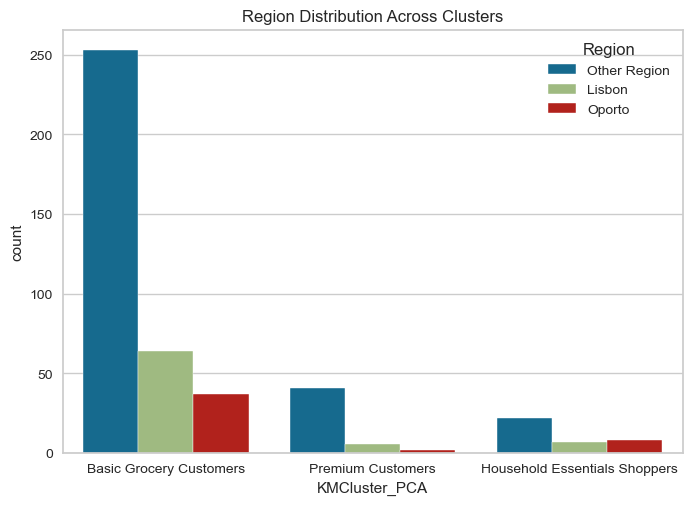

In [431]:
# we should also utilise the two features that we omitted in the beginning (region and channel)
# let's see the region distribution for each cluster

df["Region"] = df["Region"].replace({1: "Lisbon", 2: "Oporto", 3: "Other Region"})
df["KMCluster_PCA"] = df["KMCluster_PCA"].replace({0: "Basic Grocery Customers", 1: "Premium Customers", 2: "Household Essentials Shoppers"})


sns.countplot(x='KMCluster_PCA', hue='Region', data=df)
plt.title('Region Distribution Across Clusters')
plt.show()

# not very helpful
# more detailed regions should be provided
# lisbon more prominent that Porto (or Oporto idk)

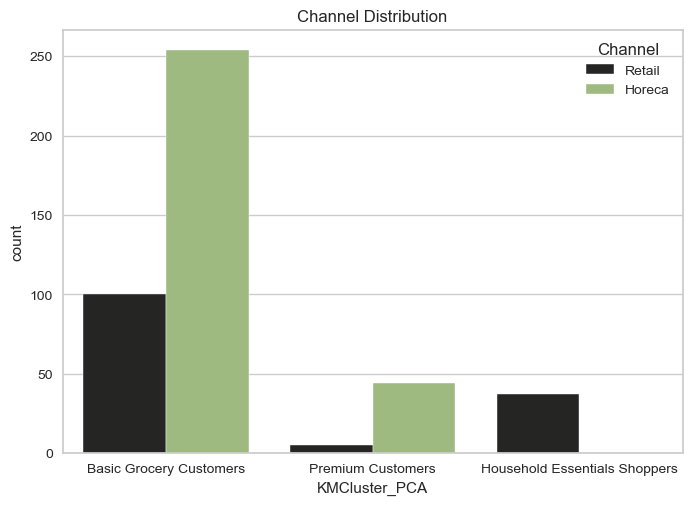

In [96]:
# channel looks like a dependent class 
# we can try and confirm if the definition given to clusters aligns with the channel feature 

df["Channel"] = df["Channel"].replace({1: "Horeca", 2: "Retail"})

sns.countplot(x='KMCluster_PCA', hue='Channel', data=df, color='g')
plt.title('Channel Distribution')
plt.show()

In [433]:
# this tracks since horeca customers are more prominent in the dataset

# and also horeca buyers prefer bulk quantities -hence the bigger numbers in basic grocery shopping- and more premium products for their businesses
# and do not buy household essentials at all
# retail customers buy the household essentials and have a good presence in the basic grocery shopping

### Clustering Algorithms:

#### Agglomerative (Hierarchical Clustering)

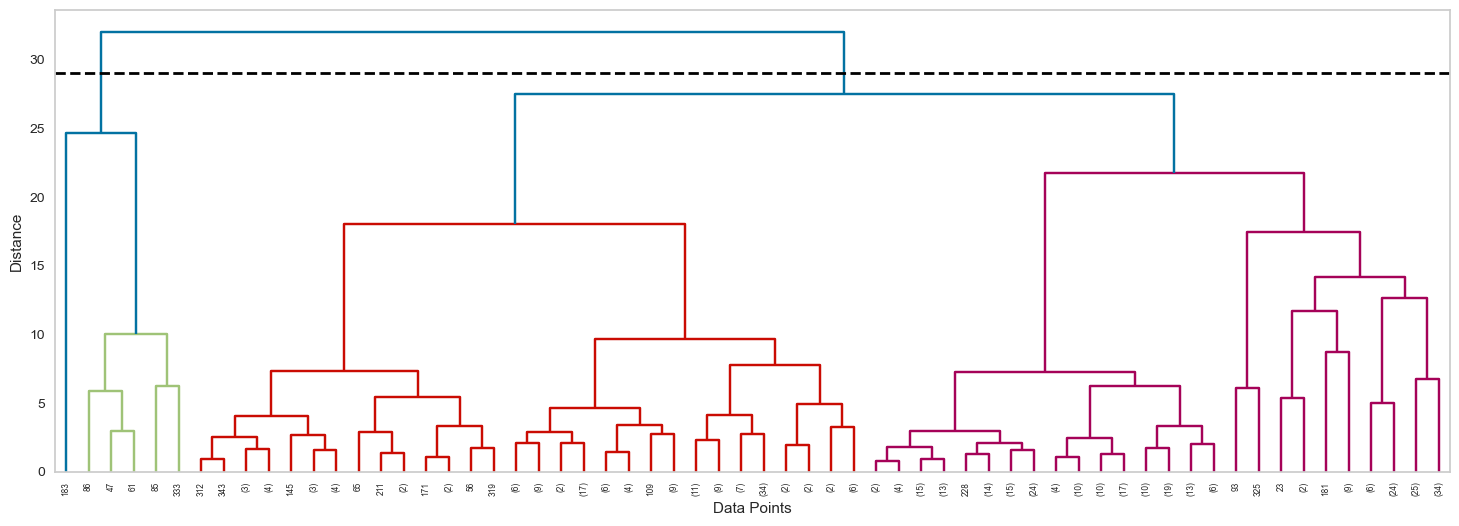

In [103]:
# agglomerative leverages a bottom-up approach to make clusters

# dendrogram plot to decide number of clusters

Z = linkage(X_scaled, method='ward', metric='euclidean')

threshold=29

plt.figure(figsize=(18,6))
dendrogram(Z, truncate_mode='level', p=6) # zooming in for visibility
plt.axhline(y=threshold, color='black', linestyle='--', linewidth=2)
plt.ylabel('Distance')
plt.xlabel('Data Points')
plt.grid(False)
plt.show()

# we've concluded in k=4, the black dash line indicates the threshold

agglo_opt_k = 4

In [105]:
# apply agglomerative in pc scores

agglomerative = AgglomerativeClustering(n_clusters = agglo_opt_k, linkage='ward', metric='euclidean')

agglomerative.fit(pc_scores)
cluster_assignment_agglo = agglomerative.labels_
cluster_assignment_agglo

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 3,
       1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [107]:
pc_scores["Cluster_Agglo"] = cluster_assignment_agglo
pc_scores.head()

,PC1,PC2,PC3,PC4,PC5,KMCluster_PCA,Cluster_Agglo
0,0.193291,-0.305100,0.140878,-0.486432,0.495281,0,1
1,0.434420,-0.328413,-0.319007,-0.178830,0.365579,0,1
2,0.811143,0.815096,-1.523416,-1.254082,-0.379054,0,1
3,-0.778648,0.652754,-0.163012,0.380060,-0.276138,0,1
4,0.166287,1.271434,-0.066279,-0.826227,-0.394211,1,1


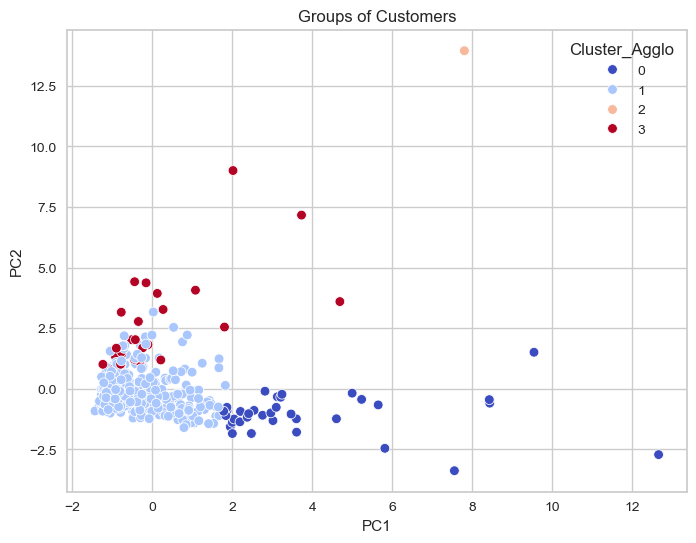

In [321]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='PC1', 
                y='PC2', 
                data=pc_scores, 
                hue= "Cluster_Agglo",
                palette="coolwarm"
               ).set_title('Groups of Customers')
plt.show()

In [111]:
# lets' try to decipher

df['Cluster_Agglo'] = cluster_assignment_agglo 
df.head()

# mean for each feature in each cluster
cluster_means = df.groupby('Cluster_Agglo')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']].mean()
cluster_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Cluster_Agglo,,,,,,
0,8214.083333,20093.055556,30700.888889,1843.138889,15048.333333,2068.694444
1,9801.350267,4309.307487,5820.056150,2672.473262,1851.577540,1202.807487
2,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000
3,44202.482759,5909.517241,6774.448276,8595.103448,1151.310345,3402.655172


In [113]:
print('General mean feature values for reference: \n\n', df.iloc[:, 2:8].describe().loc[['mean']].round(2))

General mean feature values for reference: 

         Fresh     Milk  Grocery   Frozen  Detergents_Paper  Delicatessen
mean  12000.3  5796.27  7951.28  3071.93           2881.49       1524.87


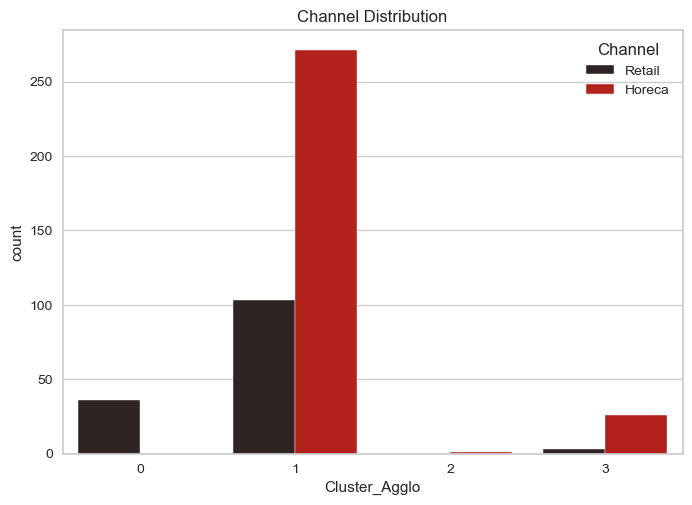

In [115]:
sns.countplot(x='Cluster_Agglo', hue='Channel', data=df, color='r')
plt.title('Channel Distribution')
plt.show()

In [117]:
# i mean... we could further separate the premium customers to premium-ish and premium-er?
# it could be useful for targeting horeca big spenders

### Clustering Algorithms:

#### DBSCAN

In [124]:
# last but not least let's try this density-based algorithm
# this way we can also detect outliers

# heatmap to find optimal model parameters (eps & min_samples)

eps  = np.linspace(.3, 2.0, 20)
mins = np.arange(3, 50, 2)
Z = np.zeros((len(eps), len(mins)))

for i, e in enumerate(eps):
    for j, m in enumerate(mins):
        db = DBSCAN(eps=e, min_samples=m)
        clusters_found = len(np.unique(db.fit_predict(pc_scores)))
        Z[i,j] = clusters_found

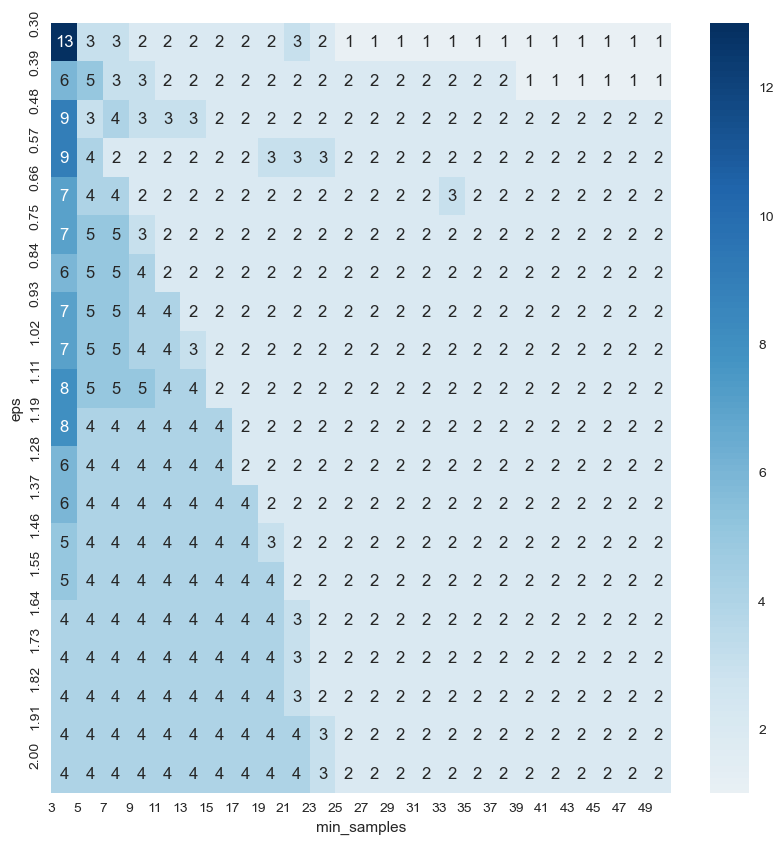

In [125]:
plt.figure(figsize=(10, 10))
sns.heatmap(Z, cmap='RdBu', center=0, annot=True);
plt.xticks(np.arange(Z.shape[1]), mins)
plt.xlabel('min_samples')
plt.yticks(np.arange(Z.shape[0]), ['%0.2f' % x for x in eps])
plt.ylabel('eps')
plt.show()

In [128]:
# try to find region in heatmap that the number of clusters does not fluctuate when tweaking eps and min_samples
# therefore....
opt_eps = 1.20
opt_min_samples = 11

In [130]:
# applying DBSCAN algorithm

db = DBSCAN(eps=opt_eps, min_samples=opt_min_samples)
db.fit(pc_scores)
cluster_assignment_dbscan = db.labels_
cluster_assignment_dbscan

array([ 0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1,  1,  0,  0,  0,  1,
        0,  0, -1,  0,  0, -1, -1,  0,  0,  2,  0, -1,  2, -1,  0,  2,  0,
        0,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  2,  2, -1,  0,
        0,  2,  0,  0,  0,  2,  0, -1,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [132]:
print ('Number of clusters found', len(np.unique(cluster_assignment_dbscan)))
print ('Clusters found', np.unique(cluster_assignment_dbscan))

Number of clusters found 4
Clusters found [-1  0  1  2]


In [134]:
pc_scores["Cluster_DBSCAN"] = cluster_assignment_dbscan
pc_scores.head()

,PC1,PC2,PC3,PC4,PC5,KMCluster_PCA,Cluster_Agglo,Cluster_DBSCAN
0,0.193291,-0.305100,0.140878,-0.486432,0.495281,0,1,0
1,0.434420,-0.328413,-0.319007,-0.178830,0.365579,0,1,0
2,0.811143,0.815096,-1.523416,-1.254082,-0.379054,0,1,-1
3,-0.778648,0.652754,-0.163012,0.380060,-0.276138,0,1,0
4,0.166287,1.271434,-0.066279,-0.826227,-0.394211,1,1,-1


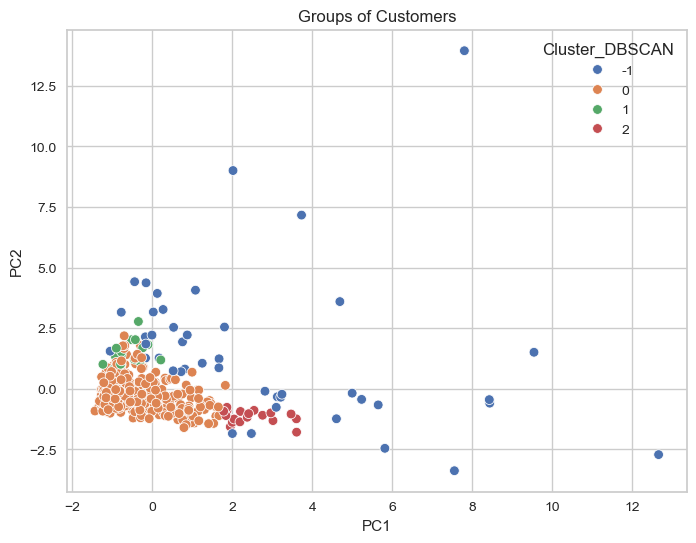

In [324]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='PC1', 
                y='PC2', 
                data=pc_scores, 
                hue= "Cluster_DBSCAN",
                palette="deep"
               ).set_title('Groups of Customers')
plt.show()

In [138]:
df['Cluster_DBSCAN'] = cluster_assignment_dbscan 
df.head()

# mean for each feature in each cluster
cluster_means = df.groupby('Cluster_DBSCAN')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']].mean()
cluster_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Cluster_DBSCAN,,,,,,
-1,23598.659091,17670.159091,20620.340909,9056.840909,8442.477273,5372.954545
0,9414.854749,4027.745810,5739.405028,2397.360335,1876.902235,1073.818436
1,41070.105263,3537.789474,4311.894737,3501.894737,725.631579,1459.789474
2,4786.315789,13879.947368,23928.105263,1492.526316,11087.894737,1177.368421


In [140]:
print('General mean feature values for reference: \n\n', df.iloc[:, 2:8].describe().loc[['mean']].round(2))

General mean feature values for reference: 

         Fresh     Milk  Grocery   Frozen  Detergents_Paper  Delicatessen
mean  12000.3  5796.27  7951.28  3071.93           2881.49       1524.87


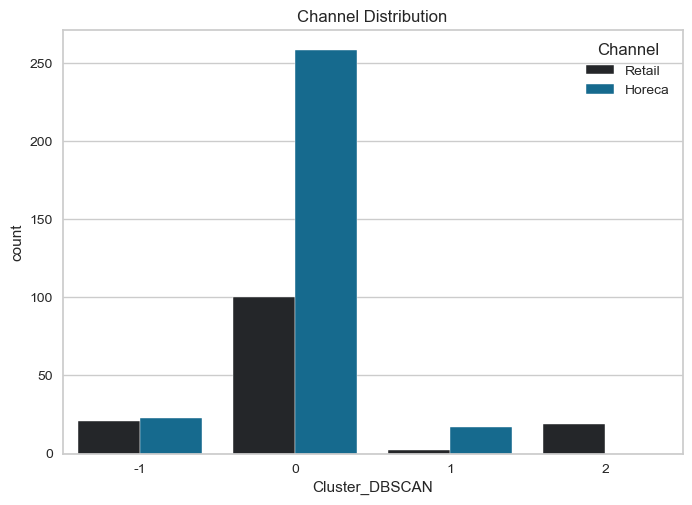

In [142]:
sns.countplot(x='Cluster_DBSCAN', hue='Channel', data=df, color='b')
plt.title('Channel Distribution')
plt.show()

In [570]:
# it certainly detects outliers
# however, it was decided to not remove them because of domain knowledge, 
# high spending is relatable in this specific dataset
# dbscan not very descriptive for this specific dataset
# does not create defined clusters

In [326]:
# xoxo